# TestGrid In-Depth EDA

In our previous notebook, [TestGrid_EDA](https://github.com/aicoe-aiops/ocp-ci-analysis/blob/master/notebooks/TestGrid_EDA.ipynb), we did some straightforward data access and preprocessing work in order to take a look at what data TestGrid exposes, how to access it and convert the test grids themselves into 2d numpy arrays. While performing that initial data exploration we came up with a few more questions around how to look at this data in aggregate that we want to address here.     

In this notebook we will address the following questions:

* How comparable are the TestGrids?
    
* How do we analyze the TestGrids in aggregate to learn from their combined behavior?

* How many/ which are the most common?
    
* Are their time series dates comparable?

* Are there sub-groups that should only be compared with one another?
    
* Is looking at the grid matrices independent of test names a valid approach for issue identification?

* What is the expected behavior of a test over time across multiple jobs.

* How does the entire test platform/specific tests perform on a given day?

* How does a test/ the entire test platform behavior evolve over time.

* Is there sufficient data here for useful ML approaches?

* Can we develop some meaningful alerting/ problem identification with the results of the above questions?
 


In [1]:
import gzip
import json
import re
import pandas as pd
import numpy as np
from itertools import groupby
from scipy.stats import kurtosis
from scipy.signal import convolve2d
import datetime
from sklearn.linear_model import Ridge
from sklearn.cluster import DBSCAN
from sklearn.decomposition import IncrementalPCA

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (20, 10)})
%matplotlib inline

In [2]:
# Include necessary function from TestGrid_EDA.ipynb
def decode_run_length(x):
    lst = []
    for run_length in x:
        extension = [run_length["value"]] * run_length["count"]
        lst.extend(extension)
    return lst

In [3]:
with gzip.open("../data/raw/testgrid_810.json.gz", "rb") as read_file:
    data = json.load(read_file)

## 1. How comparable are the TestGrids?

Lets start by answering the first question on our list, "How comparable are the TestGrids?"

TestGrids are made of a set of tests which either pass or failing over time, essentially they are multidimensional time series where the values can take either 12 (fail), 1 (pass) or 0 (not run). So we want to know if they are always the same shape, and composed of the same tests. And if not, how they vary.     

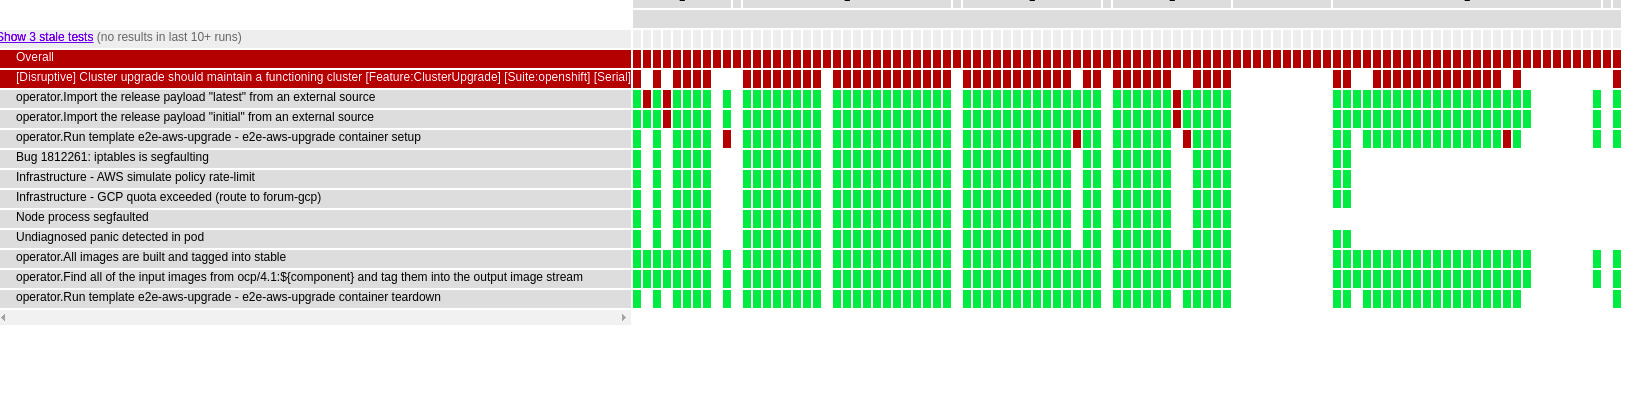

In [4]:
Image(filename="../docs/assets/images/testgrid_0.png")

### 1.a) Are there duplicate grids?

The first thing we will do is look at all the summaries and grid names to see where there is overlap. Are there duplicate grids for different platforms? 

In [5]:
# count all grids and uniquely nameed grids
c = 0
grid_names = set()
for i in data.keys():
    for j in data[i].keys():
        grid_names.add(j)
        c += 1
print(len(grid_names))
print(c)

403
403


It appears as though the answer to our question, "are there duplicate grid" is no. There a 403 individual grids by name and all grids appear to be unique. However, there seems to be a lot of similarity in naming convention between grids where only the only difference is version number. Let's remove those references and see how many groups there are and how they compare.   

### 1.b) Are there  sub-groups?

In [6]:
# count all the unique grids with version numbers removed.
c = 0
grid_names = set()
for i in data.keys():
    for j in data[i].keys():
        remove_version = re.sub(r"\d", "X", j)
        grid_names.add(remove_version)
        c += 1
print(len(grid_names))
print(c)

131
403


Great, we can now see that there are 131 grid types if we remove the version. This means that on average, a grid type is repeated about 3 times. Or stays useful for 3 versions. 

This might represent a challenge since that is a fair amount of uniqueness when it comes to making statistical claims about the behavior of these grids (if there are only 3 members of each sample). 

Now that we have identified these 131 cross-version grid types, lets look at each and see, what percent of tests they share. Can they be compared directly (do they have the same shape and tests)? 

### 1.c) Which tests do the groups all share?

In [7]:
shared_test = {}
for k in grid_names:
    k_list = []
    for i in data.keys():
        for j in data[i].keys():
            remove_version = re.sub(r"\d", "X", j)
            if remove_version == k:
                k_list.append([x["name"] for x in data[i][j]["grid"]])

    total_tests = len(set([item for sublist in k_list for item in sublist]))

    for g, l in enumerate(k_list):
        if g == 0:
            intersect = set(l)
        else:
            intersect = intersect.intersection(set(l))

    shared_test[k] = intersect
    if len(k_list) > 1:
        print(k)
        print(
            f"{len(k_list)} grids in this group, {len(intersect)} \
            shared tests out of {total_tests} unique tests in this grid type"
        )

release-openshift-origin-installer-eXe-aws-shared-vpc-X.X
5 grids in this group, 36             shared tests out of 2494 unique tests in this grid type
release-openshift-ocp-installer-eXe-aws-fips-X.X
6 grids in this group, 0             shared tests out of 2558 unique tests in this grid type
promote-release-openshift-machine-os-content-eXe-aws-X.X
7 grids in this group, 1             shared tests out of 2875 unique tests in this grid type
release-openshift-ocp-installer-eXe-openstack-serial-X.X
6 grids in this group, 3             shared tests out of 211 unique tests in this grid type
release-openshift-ocp-installer-eXe-metal-X.X
6 grids in this group, 3             shared tests out of 2651 unique tests in this grid type
periodic-ci-openshift-release-master-ocp-X.X-eXe-vsphere-serial
2 grids in this group, 110             shared tests out of 142 unique tests in this grid type
release-openshift-ocp-installer-eXe-aws-proxy-X.X
2 grids in this group, 623             shared tests out of 1

For each grid type there is between 1 and 7 individual grids, and for the vast majority of these types, there is very little overlap in the tests used across them all. There appear to be some exceptions, here that we can look into more closely later on. But as far as addressing the question "how comparable are the grids". I think the answer hear appears to be, Not vary.   

Therefore, analyzing the behavior of our jobs based on comparing grids (if we assume tests as the fundamental unit of these grids) does not appear to be a reasonable approach. We may still be able to do this looking purely at the grid patterns independent of tests names, but this will be explored further below. 

## 2. How comparable are individual tests?

Lets ignore the grids as whole units for a minute and examine the occurrence of specific tests. Which are the most common? How many many unique tests are there? How should we expect them to behave?  

### 2.a) What are the  most common tests? 

In [8]:
# Count the number of tests present across the entire platform
all_tests = []
for i in data.keys():
    for j in data[i].keys():
        tests = [x["name"] for x in data[i][j]["grid"]]
        all_tests.append(tests)

all_tests = [item for sublist in all_tests for item in sublist]

In [9]:
len(all_tests)

177291

In [10]:
# This tells us what percent a specific test is present across all grids. Where c is the total number of tests.
pd.Series(all_tests).value_counts() / c

Overall                                                                                                                                                                                                                                                                                                                   0.915633
operator.All images are built and tagged into stable                                                                                                                                                                                                                                                                      0.786600
operator.Import the release payload "latest" from an external source                                                                                                                                                                                                                                                      0.751861
operator install kube-controlle

In [11]:
# This tells us the count of a specific test and filters only for tests that occur at least 10 times
test_counts = pd.Series(all_tests).value_counts()
test_counts[test_counts.values > 10]

Overall                                                                                                                                                                                            369
operator.All images are built and tagged into stable                                                                                                                                               317
operator.Import the release payload "latest" from an external source                                                                                                                               303
operator install kube-controller-manager                                                                                                                                                           215
operator install operator-lifecycle-manager                                                                                                                                                        215
     

We can see above that there are **177,291 test instances** across all **403 grids**. Of those tests, there are only **7,798 unique tests** which is over a **~20x reduction**. 

Somewhat contrary to the findings in the earlier section, this tells us that there is a fair amount of overlap of tests among grids. Perhaps our criteria for comparison above was too strict, and we should employ some more fuzzy matching methods. 

We can also see that of these ~7k unique tests, 3,137 (about 1/3) occur across at least 10 grids. So it is probably this subset that we could use for comparisons and determining average behavior of a test overtime. 

Let's look at one of the most common tests and see what we can say about its overall behavior. 

### 2.b) Single Test Behavior Analysis 

We will use "operator.All images are built and tagged into stable" since it looks like it impacts ~80% of our grids. 

In [12]:
target_test = "operator.All images are built and tagged into stable"

In [13]:
collected_target_tests = []
timestamps = []
for i in data.keys():
    for j in data[i].keys():
        grid = data[i][j]["grid"]

        if len(grid) == 0:
            continue
        if target_test in [x["name"] for x in grid]:
            test_data = [
                x["statuses"] for x in grid if x["name"] == target_test
            ]
            collected_target_tests.append(test_data)
            timestamps.append(data[i][j]["timestamps"])

In [14]:
def get_timeseries_by_name(data, test_name):
    collected_target_tests = []
    timestamps = []
    for i in data.keys():
        for j in data[i].keys():
            grid = data[i][j]["grid"]

            if len(grid) == 0:
                continue
            if test_name in [x["name"] for x in grid]:
                test_data = [
                    x["statuses"] for x in grid if x["name"] == test_name
                ]
                collected_target_tests.append(test_data)
                timestamps.append(data[i][j]["timestamps"])
    ts_data = pd.DataFrame(
        zip(collected_target_tests, timestamps), columns=["values", "time"]
    )
    ts_data["values"] = (
        ts_data["values"].apply(lambda x: x[0]).apply(decode_run_length)
    )
    ts_data["time"] = ts_data["time"].apply(lambda x: (np.array(x) // 1000))
    ts_data["time"] = ts_data["time"].apply(
        lambda x: [datetime.datetime.fromtimestamp(y) for y in x]
    )

    return ts_data

In [15]:
print(len(collected_target_tests))
print(len(timestamps))

317
317


Great this particular test has 317 examples, which means of the 403 grids its used in 78%. Let see if we have roughly the same number of samples for each instance of this test. 

In [16]:
pd.DataFrame(collected_target_tests, columns=["RL"])["RL"].apply(
    decode_run_length
).apply(len)

0      118
1      867
2      181
3       15
4       15
      ... 
312     32
313    104
314     30
315     23
316     50
Name: RL, Length: 317, dtype: int64

So we can see from the above output that the we have a very different number of data points for a test depending on which grid it is associated with. This again, creates a problem for making direct comparisons between these tests. 

But that's alright, there are a number of ways this issue can be addressed. For now, lets go ahead, and generate some statistics about each time series. We can then define "normal behavior" as the average of these statistics as an initial naive way of comparing tests in aggregate. 

In [17]:
# Create a dataframe for all of the "operator.All images are built and tagged into stable" time series data
ts_data = pd.DataFrame(
    zip(collected_target_tests, timestamps), columns=["values", "time"]
)

In [18]:
ts_data["values"] = (
    ts_data["values"].apply(lambda x: x[0]).apply(decode_run_length)
)
ts_data["time"] = ts_data["time"].apply(lambda x: (np.array(x) // 1000))
ts_data["time"] = ts_data["time"].apply(
    lambda x: [datetime.datetime.fromtimestamp(y) for y in x]
)

In [19]:
ts_data.head(1)

,values,time
0,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[2020-10-08 16:48:05, 2020-10-08 15:12:01, 202..."


0.940677966101695% pass


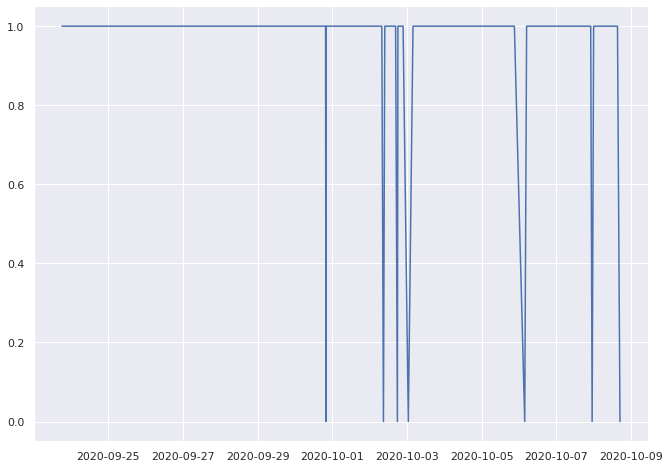

0.9319492502883506% pass


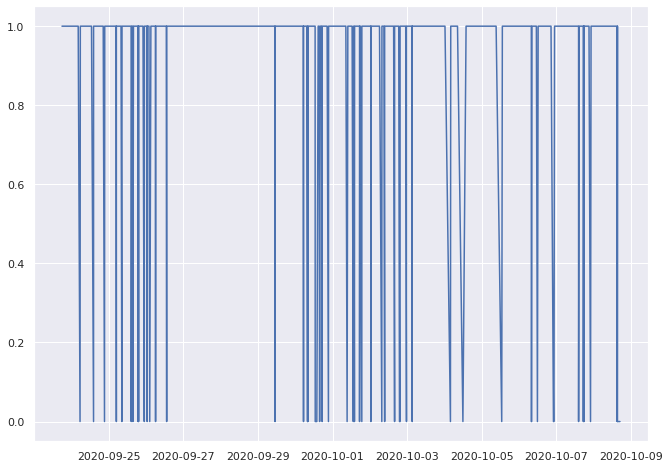

0.9668508287292817% pass


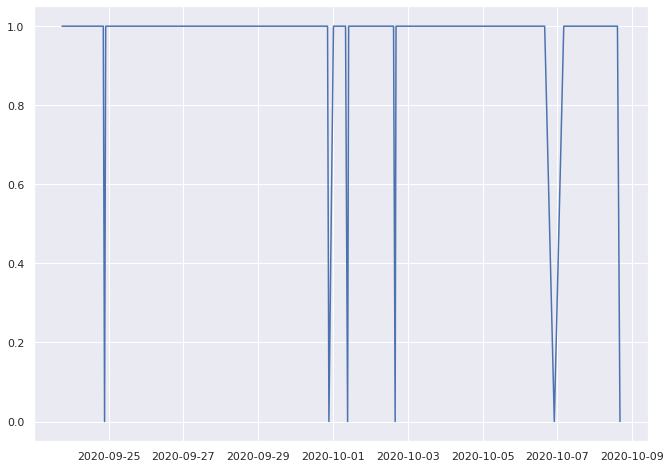

0.7333333333333333% pass


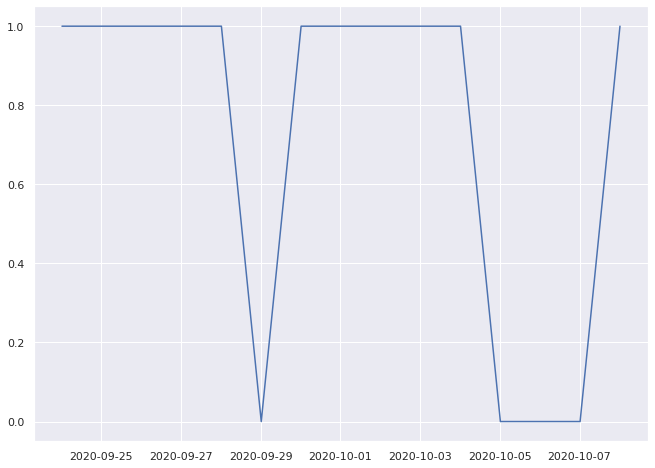

1.0% pass


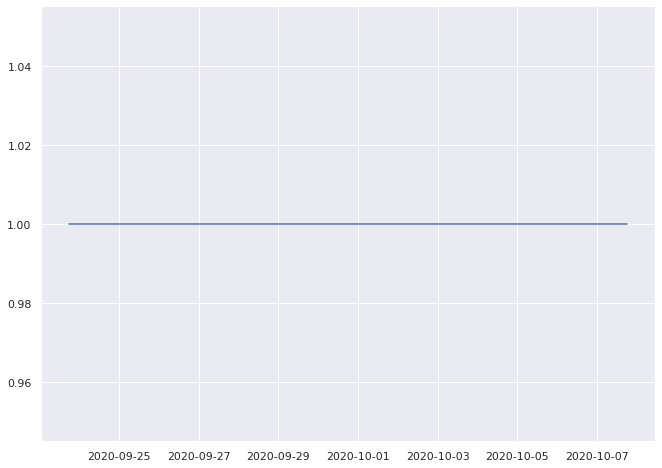

1.0% pass


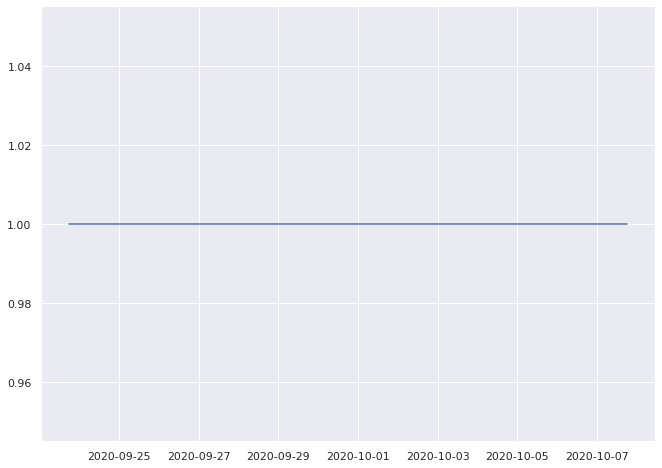

0.9333333333333333% pass


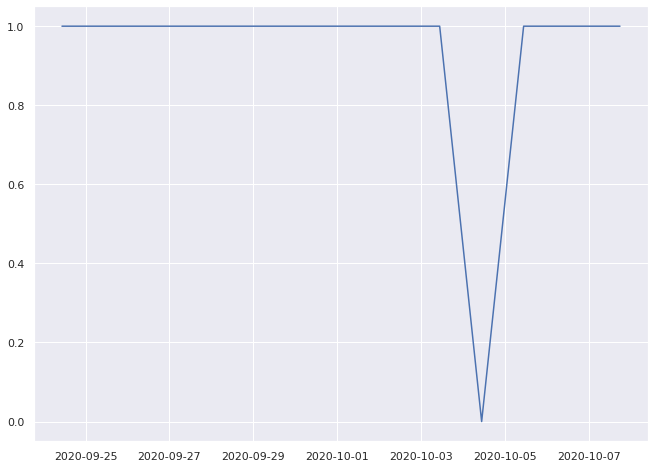

1.0% pass


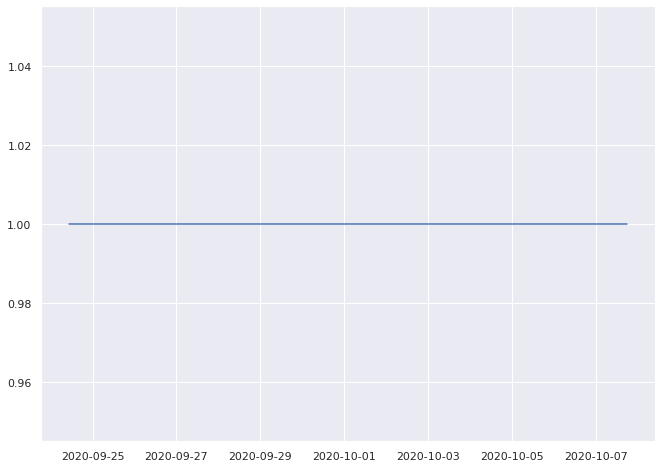

0.8333333333333334% pass


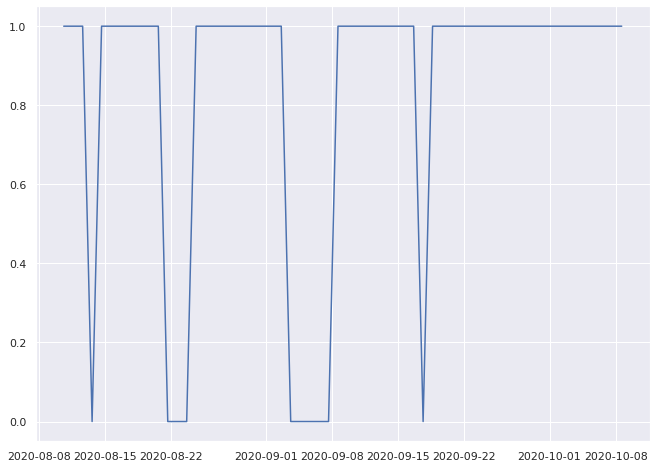

0.8333333333333334% pass


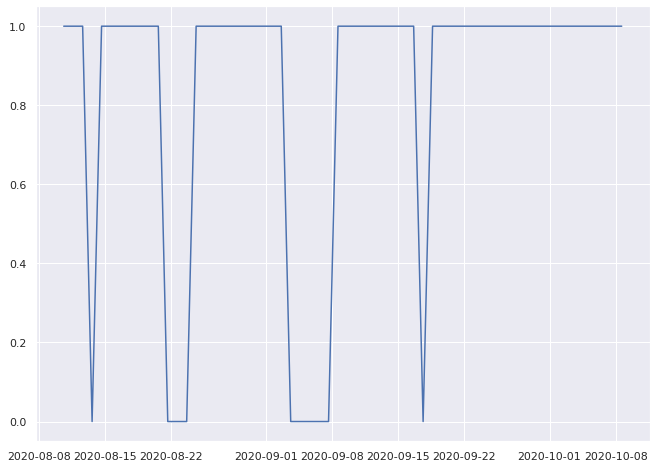

In [20]:
### Plot the first ten time series to see what we are working with

sns.set(rc={"figure.figsize": (11, 8)})
for i in range(len(ts_data))[0:10]:
    print(f"{sum(ts_data.loc[i,'values'])/len(ts_data.loc[i,'values'])}% pass")
    plt.plot(ts_data.loc[i, "time"], ts_data.loc[i, "values"])
    plt.show()

Since these time series are of unequal length, and we want to encode their general behavior to make comparisons, lets convert each of them into a vector of features based on some statistical properties of the time series. 

Selected Features
* pass rate
* regression slope
* regression intercept
* longest failure streak ratio
* kurtosis ration
* largest frequency ratio.

There are obviously many ways to convert time series into a fixed length feature vector. But we'll use these as I think they are fairly interesting and will allow us to move forward. **But I encourage future contributors to question/update/change these selected features. :)**

In [21]:
# Functions for calculating each feature from the time seires.


def get_regression_coefs(data):
    lr = Ridge()
    x = np.array(range(len(data))).reshape(-1, 1)
    y = np.array(data).reshape(-1, 1)
    lr.fit(x, y)
    line = lr.predict(x)
    return lr.coef_, line[0]


def longest_failure_streak(x):
    prev_streak = 0
    for n, c in groupby(x):
        if n == 12:
            count = sum(1 for i in c)
            if count > prev_streak:
                prev_streak = count

    return prev_streak


def largest_frequncy(x):
    f = np.fft.fft(x).real / len(x)
    f = f[range(int(len(x) / 2))]
    if len(f[1:]) > 0:
        return f[1:].argmax() / len(x)
    else:
        return 0

In [22]:
def get_test_individual_behavior(test):
    description = []
    for i, ts in enumerate(test):
        pass_rate = sum([x for x in ts if x == 1]) / len(ts)
        coef, intercept = get_regression_coefs(ts)
        failure_streak = longest_failure_streak(ts) / len(ts)
        kurtosiss = kurtosis(ts) / len(ts)
        frequency = largest_frequncy(ts)
        description.append(
            (
                pass_rate,
                float(coef),
                float(intercept),
                failure_streak,
                kurtosiss,
                frequency,
            )
        )

    return description

In [23]:
indivudial_metric = pd.DataFrame(
    get_test_individual_behavior(ts_data["values"]),
    columns=[
        "pass_rate",
        "slope",
        "intercept",
        "failures_streak",
        "kurtosis",
        "frequency",
    ],
)

In [24]:
indivudial_metric

,pass_rate,slope,intercept,failures_streak,kurtosis,frequency
0,0.940678,0.001494,0.853298,0.0,0.101019,0.161017
1,0.931949,0.000109,0.884678,0.0,0.011266,0.085352
2,0.966851,0.000391,0.931698,0.0,0.139232,0.016575
3,0.733333,0.046263,0.409490,0.0,-0.059091,0.200000
4,1.000000,0.000000,1.000000,0.0,-0.200000,0.000000
...,...,...,...,...,...,...
312,0.968750,0.002382,0.931832,0.0,0.844758,0.250000
313,0.990385,0.000549,0.962088,0.0,0.952016,0.298077
314,0.966667,-0.004225,1.027930,0.0,0.834483,0.066667
315,0.782609,0.002962,0.750032,0.0,-0.005314,0.304348


We've now converted our 317 variable length binary time series data into a tabular data set with 6 features that represent the behavior of our tests over time.

The benefit of doing this is that we can now apply some classic machine learning approaches, like  dimensionality reduction and clustering to our data.  

Lets visualize the instances of this test and see if any obvious structure jumps out.  

#### Visualizing our tests

First we will apply PCA to reduce our 6 dimensional data down to 2 for plotting. Then we will apply DBSCAN to identify any clusters or outliers that might be present in our data. 

In [25]:
X = indivudial_metric
ipca = IncrementalPCA(n_components=2, batch_size=10)
ipca.fit(X)
two_d = ipca.transform(X)

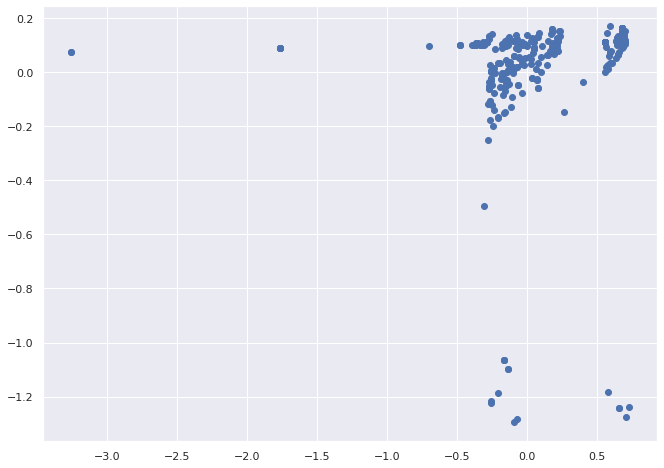

In [26]:
plt.scatter(two_d[:, 0], two_d[:, 1])
plt.show()

In [27]:
X = indivudial_metric
cluster = DBSCAN().fit(X)

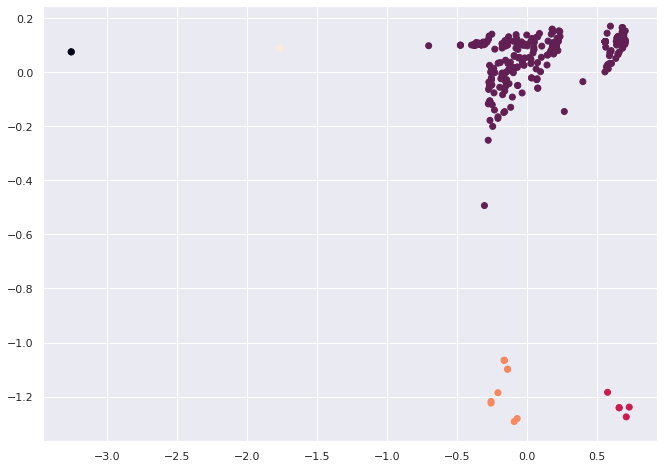

In [28]:
plt.scatter(two_d[:, 0], two_d[:, 1], c=cluster.labels_)
plt.show()

It looks like this method works to cluster individual test behavior across multiple instances of the same test. In this case we have divide the space into 3 clusters with a couple of outliers that we could investigate further.

For the purposes of this notebook, we will move on, however, as we established  at least one method for encoding and categorizing the behavior of tests that are all of the same type.

In the future this could be used to classify different types of observed errors for tests found in TestGrids

### 2.c) Multiple Test Behavior 

Lets just quickly take a look at a larger portion of th entire data set that we have and see if we notice anything from clustering across multiple tests, i.e. are there types of behavior clusters we can identify.

Using all 117k tests is rather slow, so I'll limit it only to ~12k for the purposes of this notebook 

In [29]:
first_pass = True

for i in all_tests[1:200]:
    if first_pass:
        tsx = get_timeseries_by_name(data, i)
        tsx["name"] = i
        first_pass = False
    else:
        next_ts = get_timeseries_by_name(data, i)
        next_ts["name"] = i
        tsx = tsx.append(next_ts, ignore_index=True)

In [30]:
tsx.shape

(11927, 3)

In [31]:
indivudial_metric = pd.DataFrame(
    get_test_individual_behavior(tsx["values"]),
    columns=[
        "pass_rate",
        "slope",
        "intercept",
        "failures_streak",
        "kurtosis",
        "frequency",
    ],
)

In [32]:
indivudial_metric.head()

,pass_rate,slope,intercept,failures_streak,kurtosis,frequency
0,0.016949,-0.036272,3.765972,0.016949,0.021369,0.084746
1,0.237601,0.001266,1.793203,0.008074,0.000992,0.003460
2,0.000000,-0.076442,10.962582,0.372881,-0.015939,0.237288
3,0.000000,-0.024003,10.001448,0.166667,-0.008263,0.000000
4,0.000000,-0.056302,12.105453,0.388889,0.002778,0.022222


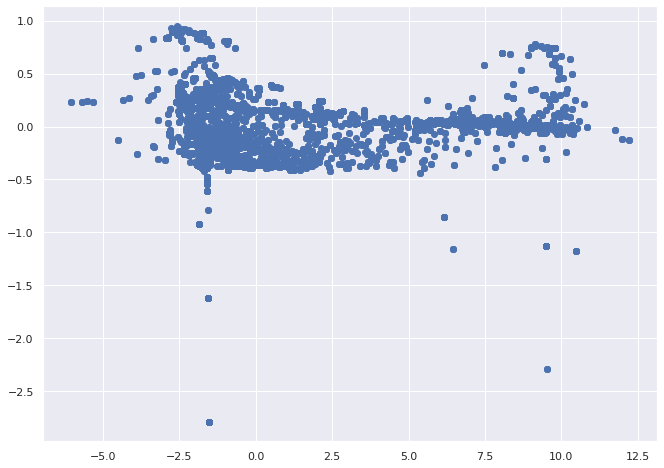

In [33]:
X = indivudial_metric
ipca = IncrementalPCA(n_components=2, batch_size=10)
ipca.fit(X)
two_d = ipca.transform(X)
plt.scatter(two_d[:, 0], two_d[:, 1])
plt.show()

In [34]:
X = indivudial_metric
cluster = DBSCAN().fit(X)

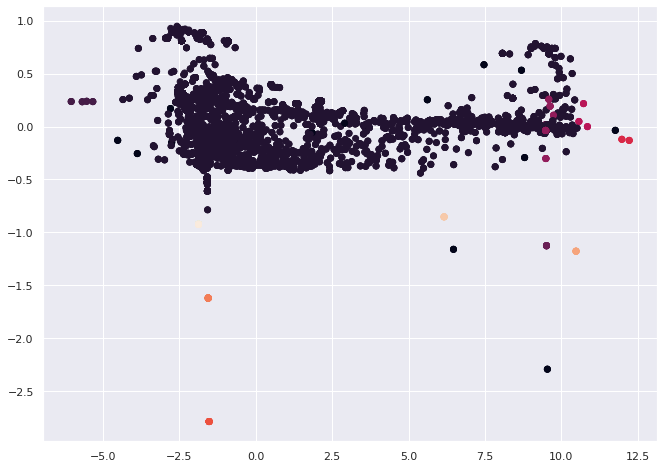

In [35]:
plt.scatter(two_d[:, 0], two_d[:, 1], c=cluster.labels_)
plt.show()

Based on the image above, its looks like we get something close to a 2d uniform distribution of our dataset with a few outliers if we take a larger portion of our tests at once with this feature set. 

This might be noise or it might show that most time series behave in a similar way, or cluster into one of the other 9 failure types.  

In either case, we can use these methods outlined above to investigate this approach further in a later notebook.

### 2.d)  Comparing the tests in aggregate 

Now that we've looked at individual tests, lets derive a new object that describes a single test as the aggregation of the features we've defined above for every instance of the same test. 

In [36]:
def get_test_behavior(test):
    description = {}
    pass_rate = 0
    avg_coef = 0
    avg_intercept = 0
    avg_failure_streak = 0
    avg_kurtosis = 0
    avg_frequency = 0
    for i, ts in enumerate(test):
        pass_rate += sum([x for x in ts if x == 1]) / len(ts)
        coef, intercept = get_regression_coefs(ts)
        avg_coef += coef
        avg_intercept += intercept
        avg_failure_streak += longest_failure_streak(ts) / len(ts)
        avg_kurtosis += kurtosis(ts) / len(ts)
        avg_frequency += largest_frequncy(ts)

    description["pass_rate"] = pass_rate / (i + 1)
    description["avg_coef"] = float(avg_coef / (i + 1))
    description["avg_intercept"] = float(avg_intercept / (i + 1))
    description["avg_failure_streak"] = avg_failure_streak / (i + 1)
    description["avg_kurtosis"] = avg_kurtosis / (i + 1)
    description["avg_frequency"] = avg_frequency / (i + 1)

    return description

In [37]:
single_test = get_timeseries_by_name(
    data, "operator.All images are built and tagged into stable"
)
get_test_behavior(single_test["values"])

{'pass_rate': 0.911815196098699,
 'avg_coef': -0.00031722304811730484,
 'avg_intercept': 0.9199496749854382,
 'avg_failure_streak': 0.0,
 'avg_kurtosis': 0.25686846515261513,
 'avg_frequency': 0.1669826612570952}

Alright, this looks like it might be a reasonable representation for a summary of expected behavior for a test. What can this tell us? 

For the test "operator.All images are built and tagged into stable" we should expect this test to pass about 91% percent of the time regardless of the platform its run on. We have a small negative slope (avg_coef), which means on average we have more "not run" instances as we move forward in time, but this is such a small slope its practically flat, ie, this is a reliable test. If it does fail, there is 0% average failure streak, meaning if it does fail, it could fail for up to 0% of the total number of tests runs to date in a row(i.e, this test never fails, seems to only pass or not run). This value basically tells us how often we see small flips vs longer outages in our data. Finally, kurtosis and frequency are two additional measures of "steadiness" of our data, but since they are normalized here their interpretation is less direct, but can be understood in relation to other test vectors.

Now, is it useful to represent tests this way? Maybe. My concern here would be that we have over-summarized the different dynamics occurring in these individual test runs. Especially, as we saw about 3 clear clusters for this test above. However, we can validate the usefulness of these baselines by repeating the above for all the tests and seeing if there is stronger inter-test relationship than between different tests. (Basically, will the individual tests land closer to the baseline for their test or not if we measure their vector distances?)   

Lets find out and produce these vectors for each test, and compare them similar to how we did above. 

In [38]:
def get_timeseries_for_test(x, target_test):
    collected_target_tests = []
    timestamps = []
    for i in x.keys():
        for j in x[i].keys():
            grid = x[i][j]["grid"]

            if len(grid) == 0:
                continue
            if target_test in [x["name"] for x in grid]:
                test_data = [
                    x["statuses"] for x in grid if x["name"] == target_test
                ]
                collected_target_tests.append(test_data)
                timestamps.append(x[i][j]["timestamps"])

    ts_data = pd.DataFrame(
        zip(collected_target_tests, timestamps), columns=["values", "time"]
    )
    ts_data["values"] = (
        ts_data["values"].apply(lambda x: x[0]).apply(decode_run_length)
    )
    ts_data["time"] = ts_data["time"].apply(lambda x: (np.array(x) // 1000))
    ts_data["time"] = ts_data["time"].apply(
        lambda x: [datetime.datetime.fromtimestamp(y) for y in x]
    )

    return ts_data

In [39]:
vector_set = {}
test_names = list(set(all_tests))
for test in test_names:
    test_set = get_timeseries_for_test(data, test)
    vector = get_test_behavior(test_set["values"])
    vector_set[test] = vector

In [40]:
vector_set[test_names[0]]

{'pass_rate': 0.7539586117130891,
 'avg_coef': -0.0006371406635070356,
 'avg_intercept': 0.7672878478322255,
 'avg_failure_streak': 0.0,
 'avg_kurtosis': 0.05969594569818218,
 'avg_frequency': 0.17192680760898754}

In [41]:
transpo = pd.DataFrame(vector_set).T

Now that we have our data converted from individual time series into one data point for each test with 6 features representing the average behavior of a test across all of its instances. Lets visualize it and get a sense for the distribution. To plot this 6d data in 2d we will again use PCA to reduce the dimensions.     

In [42]:
X = transpo
ipca = IncrementalPCA(n_components=2, batch_size=20)
ipca.fit(X)
two_d = ipca.transform(X)

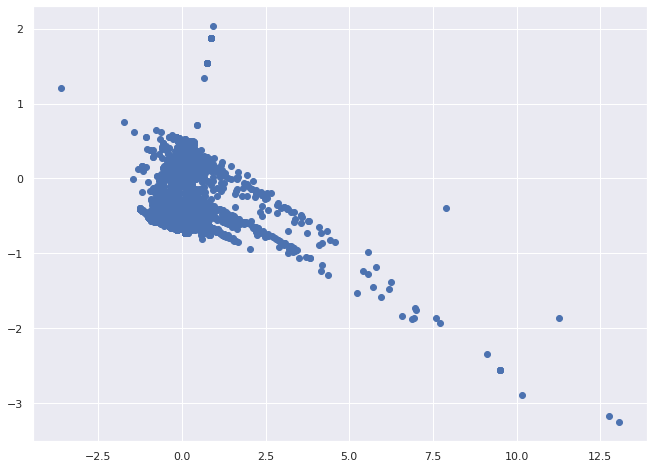

In [43]:
plt.scatter(two_d[:, 0], two_d[:, 1])
plt.show()

Clearly we can see some differentiation in this representation. Let's use DBSCAN on the 6d data and see if there is still some meaningful grouping. 

In [44]:
X = transpo
dbscan = DBSCAN().fit(X)
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0])

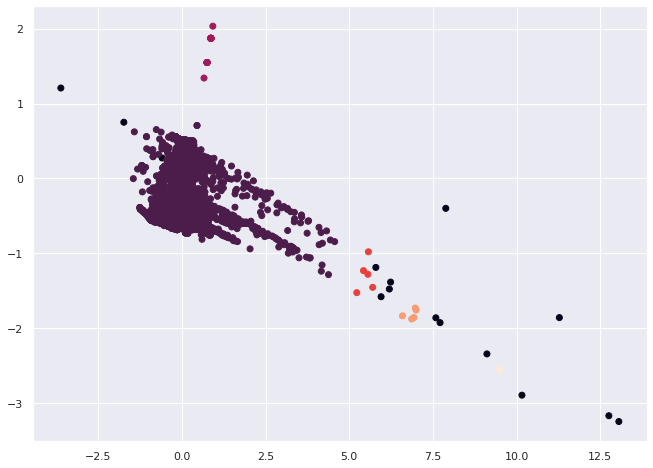

In [45]:
plt.scatter(two_d[:, 0], two_d[:, 1], c=dbscan.labels_)
plt.show()

We can see some clustering going on in the plot above, but also a fairly even distribution between tests.

However, what we want to know is if these "baseline" vectors for each test are actually meaningful. We will make that assessment by determining if individual tests are closer to their "baselines" on average then the datasets overall average? 

In [46]:
indivudial_metric = pd.DataFrame(
    get_test_individual_behavior(ts_data["values"]),
    columns=[
        "pass_rate",
        "slope",
        "intercept",
        "failures_streak",
        "kurtosis",
        "frequency",
    ],
)

In [47]:
# This is the center of our baselines.

tests_baseline = pd.DataFrame(vector_set).mean(axis=1)
tests_baseline

pass_rate             0.436850
avg_coef             -0.001499
avg_intercept         0.730979
avg_failure_streak    0.006771
avg_kurtosis          0.351694
avg_frequency         0.184582
dtype: float64

In [48]:
# for each test, get the averge distance of their test instances from their baseline and the global baseline
results = []
for i in test_names:
    indivudial_metric = get_timeseries_by_name(data, i)
    indivudial_metric = pd.DataFrame(
        get_test_individual_behavior(indivudial_metric["values"]),
        columns=[
            "pass_rate",
            "slope",
            "intercept",
            "failures_streak",
            "kurtosis",
            "frequency",
        ],
    )
    baseline = pd.Series(vector_set[i])

    group_baseline_distance = indivudial_metric.apply(
        lambda x: np.linalg.norm(x.values - baseline.values), axis=1
    ).mean()
    absolute_basline_distance = indivudial_metric.apply(
        lambda x: np.linalg.norm(x.values - tests_baseline.values), axis=1
    ).mean()

    results.append((i, group_baseline_distance, absolute_basline_distance))

local_vs_global = pd.DataFrame(
    results,
    columns=["test", "local average distance", "global average distance"],
)

In [49]:
local_vs_global.head()

,test,local average distance,global average distance
0,[Feature:Platform] ClusterOperators should def...,0.320792,0.600181
1,[sig-storage] Zone Support [Top Level] [sig-st...,0.000000,0.739335
2,operator.Run template e2e-gcp-serial - e2e-gcp...,1.902771,2.258621
3,[sig-storage] Downward API volume [Top Level] ...,0.306030,0.568613
4,[sig-storage] In-tree Volumes [Driver: azure] ...,0.094791,0.530946


In [50]:
sum(
    local_vs_global["local average distance"]
    <= local_vs_global["global average distance"]
) / len(local_vs_global)

0.9842267248012311

Great, so in 98% of cases the local average distance of individual tests to their baseline is closer than an overall baseline. This tells us that there is some usefulness in describing the expected behavior of a test based on the mean of its individual features.   

**What have we accomplished?**

So far we have looked at the girds as a whole based on their shared collection of tests, determined that that the grids themselves are all unique and not directly comparable with regard to their set of tests. 

However, some tests are repeated across many grids and we showed a couple methods to visualize, encode and analyze them both individually and in aggregate.    

## 3. How does the entire test platform or a specific tests perform on a given day?

Now that we've looked at encoding and comparing tests from a "horizontal perspective" with regard to the grids and examined the tests independent of time. Lets switch to a "vertical perspective" and determine how the entire platform, specific grids, or particular tests behave at specific days and across time. 

### 3.a) Platform performance for a given day

In order to iterate over and search by the epoch time in our dataset, lets quickly collect all the unique times where a test value was logged. 

In [51]:
times = []
for i in data.keys():
    for j in data[i].keys():
        times.extend(data[i][j]["timestamps"])
times = set(times)
times = sorted(list(times))
date = set([datetime.datetime.fromtimestamp(x // 1000) for x in times])

date = list(date)

`times` should contain every possible time stamp in our dataset.  

Now let's iterate through our dataset and collect **all** the data on our platform that occurred on our query date. 

In [52]:
tests_on_day = []
query_date = datetime.date.fromtimestamp(1601671083)
for i in data.keys():
    for j in data[i].keys():
        for t in data[i][j]["timestamps"]:
            if datetime.date.fromtimestamp(t // 1000) == query_date:
                index = data[i][j]["timestamps"].index(t)
                v = {}
                for k in data[i][j]["grid"]:
                    value = decode_run_length(k["statuses"])[index]
                    name = k["name"]
                    v[name] = value

                tests_on_day.append((i, j, t, v))

In [53]:
one_day_behaviour = pd.DataFrame(
    tests_on_day, columns=["tab", "grid", "timestamp", "tests_values"]
)
one_day_behaviour.head(2)

,tab,grid,timestamp,tests_values
0,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,1601688361000,{'Application behind service load balancer wit...
1,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,1601687169000,{'Application behind service load balancer wit...


In [54]:
one_day_behaviour["passes"] = one_day_behaviour.tests_values.apply(
    lambda x: sum([y for y in x.values() if y == 1])
)
one_day_behaviour["length"] = one_day_behaviour.tests_values.apply(
    lambda x: len(x.values())
)

In [55]:
one_day_behaviour.head(2)

,tab,grid,timestamp,tests_values,passes,length
0,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,1601688361000,{'Application behind service load balancer wit...,23,77
1,"""redhat-openshift-informing""",release-openshift-okd-installer-e2e-aws-upgrade,1601687169000,{'Application behind service load balancer wit...,56,77


In [56]:
platfrom_pass_rate = (
    one_day_behaviour.passes.sum() / one_day_behaviour.length.sum()
)
platfrom_pass_rate

0.6028508219887826

Great, so we can use this method to calculate the pass rate, or any other derived value, for the entire platform for a specific day. As we can see above, there was a 60% pass rate across the entire platform on our query day. 

We could also use this approach on a subset of the data to get behavior metrics for specific tests, grids, or custom subsets.   

Now that we know how to look at behavior for a single day across the entire platform, we could roll this out across each day to see how the platform evolves over time. 

### 3.b) Platform performance over time

Lets create a list of dates that we are interested in reviewing and plot the platform pass rate.  

In [57]:
dates = [datetime.date(2020, 9, i) for i in range(1, 25)]

In [58]:
platform_pass_rate = []
for d in dates:
    tests_on_day = []
    query_date = d
    for i in data.keys():
        for j in data[i].keys():
            for t in data[i][j]["timestamps"]:
                if datetime.date.fromtimestamp(t // 1000) == query_date:
                    index = data[i][j]["timestamps"].index(t)
                    v = {}
                    for k in data[i][j]["grid"]:
                        value = decode_run_length(k["statuses"])[index]
                        name = k["name"]
                        v[name] = value

                    tests_on_day.append((i, j, t, v))

    one_day_behaviour = pd.DataFrame(
        tests_on_day, columns=["tab", "grid", "timestamp", "tests_values"]
    )
    one_day_behaviour["passes"] = one_day_behaviour.tests_values.apply(
        lambda x: sum([y for y in x.values() if y == 1])
    )
    one_day_behaviour["length"] = one_day_behaviour.tests_values.apply(
        lambda x: len(x.values())
    )
    platfrom_pass_rate_one_day = (
        one_day_behaviour.passes.sum() / one_day_behaviour.length.sum()
    )
    platform_pass_rate.append(platfrom_pass_rate_one_day)

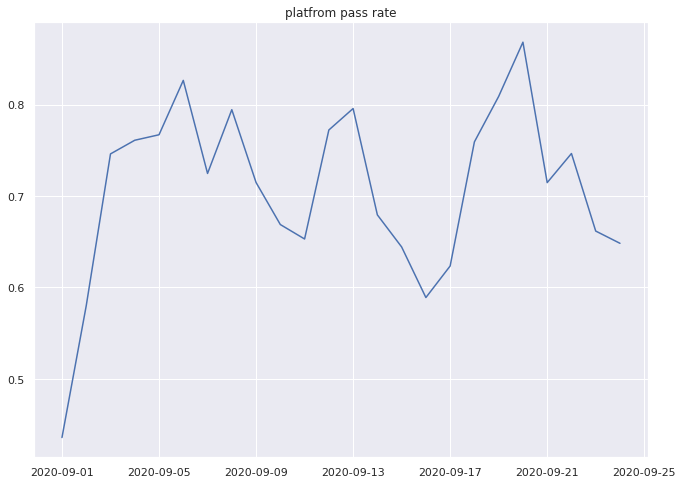

In [59]:
plt.plot(dates, platform_pass_rate)
plt.title("platfrom pass rate")
plt.show()

Great, from the above, we can now select any time period of interest (that we have data for) and examine the behavior of the entire platform over time.

And just to do our due diligence, below we will show that this can be done for individual test as well. 

### 3.c) Aggregate test performance over time

In [60]:
test_name = "operator.All images are built and tagged into stable"
ts = get_timeseries_by_name(data, test_name)
ts.head()

,values,time
0,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[2020-10-08 16:48:05, 2020-10-08 15:12:01, 202..."
1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...","[2020-10-08 16:52:49, 2020-10-08 16:52:45, 202..."
2,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2020-10-08 16:15:59, 2020-10-08 14:38:28, 202..."
3,"[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]","[2020-10-08 00:21:00, 2020-10-07 00:20:17, 202..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2020-10-07 18:04:59, 2020-10-06 18:04:21, 202..."


In [61]:
# epoch time is too specific, we only care about the day a test was run.
simple_dates = ts.time.apply(
    lambda x: [datetime.date(y.year, y.month, y.day) for y in x]
)
ts["time"] = simple_dates
ts.head()

,values,time
0,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[2020-10-08, 2020-10-08, 2020-10-08, 2020-10-0..."
1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...","[2020-10-08, 2020-10-08, 2020-10-08, 2020-10-0..."
2,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2020-10-08, 2020-10-08, 2020-10-08, 2020-10-0..."
3,"[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]","[2020-10-08, 2020-10-07, 2020-10-06, 2020-10-0..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2020-10-07, 2020-10-06, 2020-10-05, 2020-10-0..."


In [62]:
results = {}
for t in dates:
    result = []
    for i in range(len(ts)):
        if t in ts.loc[i, "time"]:
            RL_spot = ts.loc[i, "time"].index(t)
            result.append(ts.loc[i, "values"][RL_spot])
    results[t] = result

In [63]:
pass_rate = []
date = []
count = []
for k in results.keys():
    date.append(k)
    pass_rate.append(sum(results[k]) / len(results[k]))
    count.append(len(results[k]))

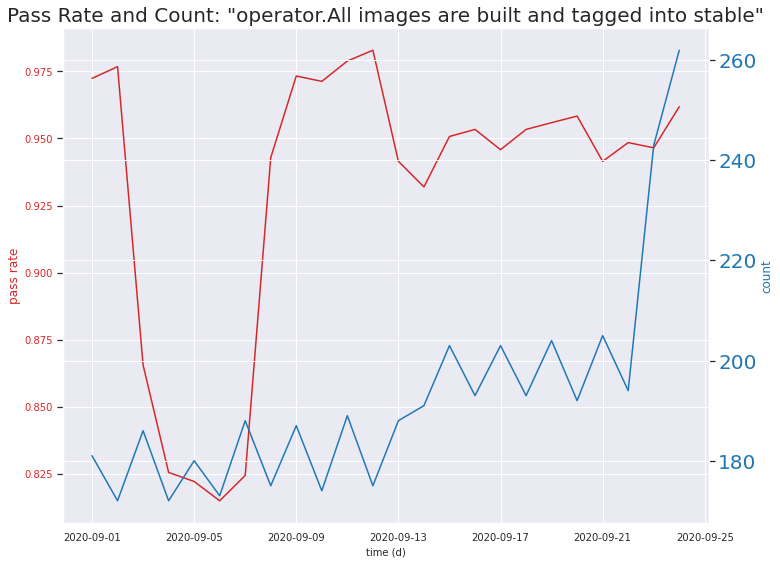

In [64]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("time (d)", fontdict={"fontsize": 10})
ax1.set_ylabel("pass rate", color=color)
ax1.plot(date, pass_rate, color=color)
ax1.tick_params(axis="y", labelcolor=color, labelsize=10)
ax1.tick_params(axis="x", labelsize=10)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("count", color=color)  # we already handled the x-label with ax1
ax2.plot(date, count, color=color)
ax2.tick_params(axis="y", labelcolor=color, labelsize=20)

plt.title(
    'Pass Rate and Count: "operator.All images are built and tagged into stable"',
    fontdict={"fontsize": 20},
)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

**What have we accomplished?** 

Above we have explored a couple of methods for visualizing and calculating metrics about the TestGrid environment given a specific time or time range. Moving forward this could be used for overall trend analysis or prediction or root cause analysis for a time period with a known issue. 

## 4. Grid Matrices as 2d Signals

Is looking at the grid matrices independent of test names a valid approach for issue identification?

I don't see why not. Lets take an example, looking at the image below we can see that it was annotated manually by a human subject matter expert. Most of these errors seem to lie either purely on the vertical or horizontal axes and can be identified by analyzing either a single test or a single day, which we've already explored above. 

### 4.a) Identify Infrastructure Flakes

But what about the infrastructure flake? That seems to be characterized by diagonal failures over multiple days. We currently do not have any way of addressing that type of data. Lets see if we can use a simple hand crafted 2d filter to start identifying these types of errors.    

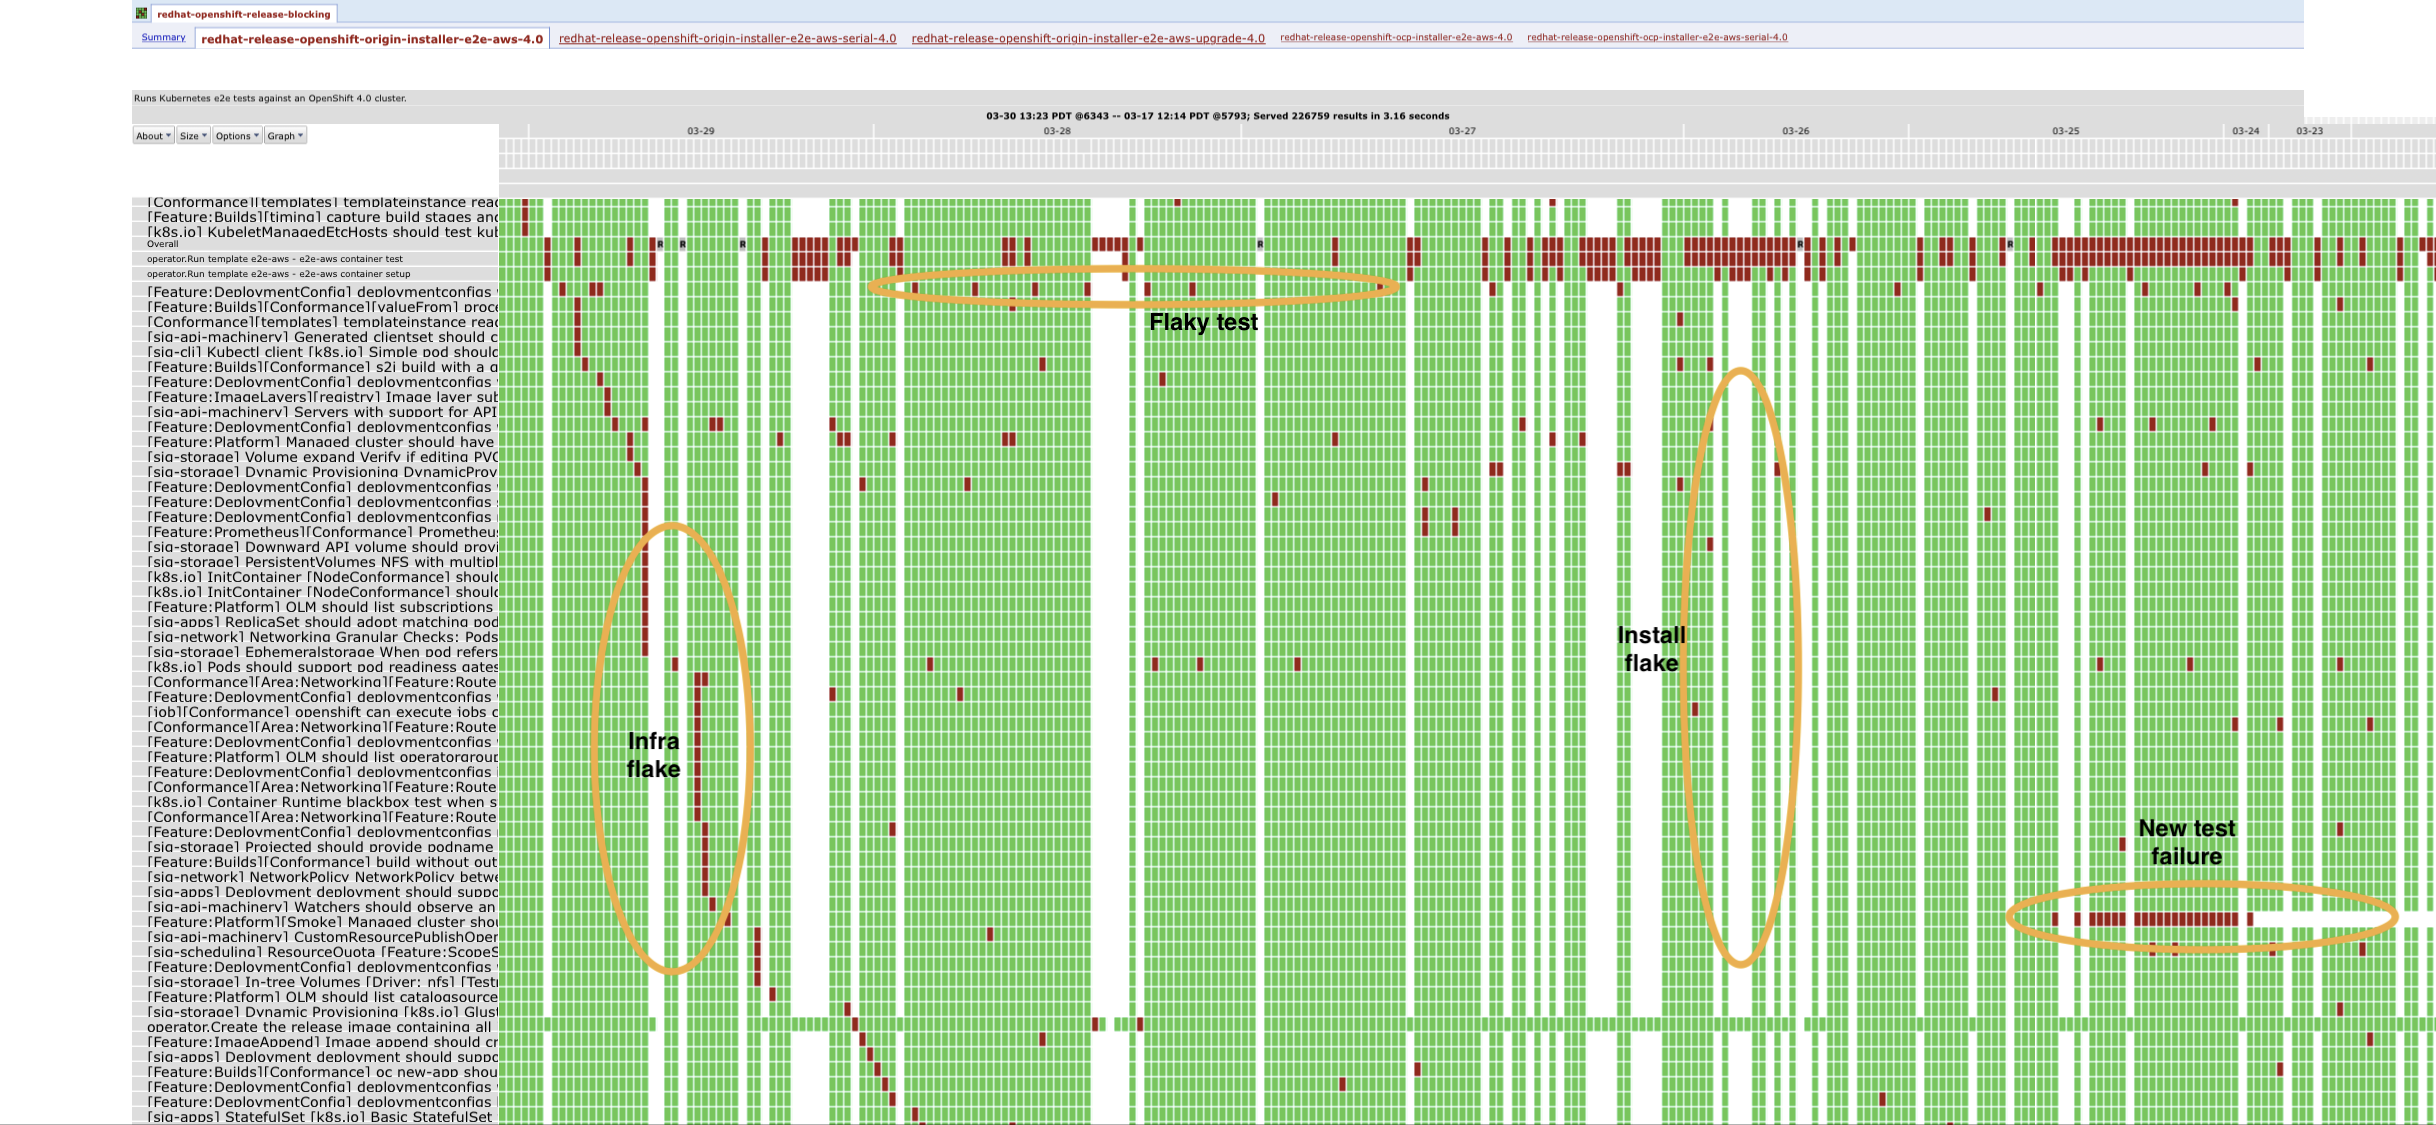

In [65]:
Image(
    "https://user-images.githubusercontent.com/161888/89903201-a62b3800-dbe7-11ea-9b1c-2ec62fe8952f.png"
)

In [66]:
# 2d filter that will have its highest value when convolved with a diagonal pattern.
infra_flake_filter = np.array([[-1, 1], [1, -1]])
infra_flake_filter

array([[-1,  1],
       [ 1, -1]])

In [67]:
grid = data['"redhat-openshift-ocp-release-4.3-informing"'][
    "release-openshift-origin-installer-e2e-gcp-compact-4.3"
]["grid"]

In [68]:
# Subset of the data where we see this infra flake pattern
grid = np.array(list(pd.DataFrame(grid).statuses.apply(decode_run_length)))
grid = grid[0:20, 0:20]

In [69]:
# we want to re-map the values so that the output of the convolution will be more interpretable.
def normalize(x):
    if x == 1:
        return 1
    if x == 12:
        return -1
    if x == 0:
        return 0


x = pd.DataFrame(grid).apply(lambda x: [normalize(y) for y in x])
x = np.array(x)

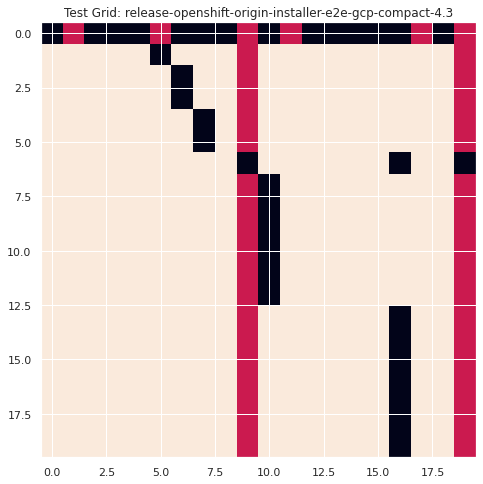

In [70]:
plt.imshow(x)
plt.title("Test Grid: release-openshift-origin-installer-e2e-gcp-compact-4.3")
plt.show()

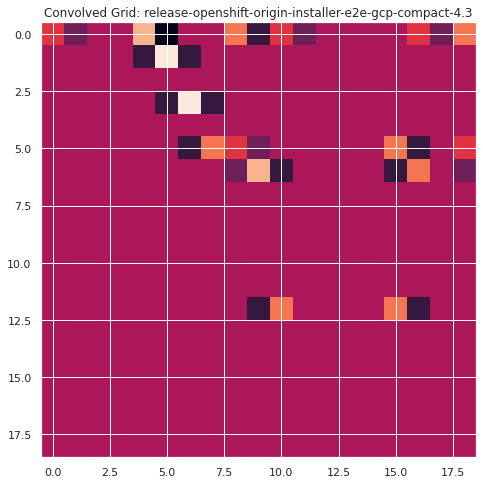

In [71]:
plt.imshow(convolve2d(infra_flake_filter, x, mode="valid"))
plt.title(
    "Convolved Grid: release-openshift-origin-installer-e2e-gcp-compact-4.3"
)
plt.show()

In [72]:
# Find the spots on the map where the convolution had its maximum value.
spots = convolve2d(infra_flake_filter, x, mode="valid")
infra_falkes = np.where(spots == 4)
infra_falkes

(array([1, 3]), array([5, 6]))

In [73]:
dates = data['"redhat-openshift-ocp-release-4.3-informing"'][
    "release-openshift-origin-installer-e2e-gcp-compact-4.3"
]["timestamps"]
infra_flake_dates = np.array(dates)[list([infra_falkes][0][1])]
for i in infra_flake_dates:
    print(
        f"possible infra flake occuring on {datetime.date.fromtimestamp(i//1000)}"
    )

possible infra flake occuring on 2020-10-02
possible infra flake occuring on 2020-10-01


**What have we accomplished?**

The above example has shown one way to automatically determined if there was an infrastructure flake in our TestGrid. This example identified 2 between October 1st and 2nd for the "release-openshift-origin-installer-e2e-gcp-compact-4.3'" grid. Now we need to follow up with an SME to validate this approach. 

## Conclusion

In this notebook, we have done additional exploration of the TestGrid data, familiarizing ourselves with it further and determined a number of facts about the nature of the grids that will help us move forward in using it to develop ML tools for CI. We have looked at the entire platform, testgrids and individual tests both from a stationary and timeseries perspective. We have also done a couple of small experiments with encoding and clustering to explore the datasets viability for applying ML approaches.  


In this notebook we have tried to address the following questions and come up with the following answers:

* **How comparable are the testgrids?**
    * The test grids contain nearly unique sets of tests and therefore are not directly comparable. We will either have to consider the aggregation of the shared test or define grids purely by their patterns (independent of specific test)
    
    
* **How do we analyze the TestGrids in aggregate to learn from their combined behavior?**
    * I don't think we can really do it directly due to the above, other then looking purely at patterns independent of the specific test names. It will likely be better to learn from the tests, then use the tests the grids are composed of to understand the grids better. 


* **How many/ which tests do they all have in common?**
    * The set of tests in each grid appears to be unique and there is not one test that is included in all grids.
    * However, there are about 3k tests identified above that that occur in more than 10 grids
    

* **Are their time series dates comparable?**
    * We have included the timestamps for the time series, so we know when a test passed/failed and we can compare tests on specific days or time ranges. 
    * They are different dates and lengths of runs, however, so they aren't all equally sampled points. 


* **Are there sub-groups that should only be compared with one another?**
    * We removed version identifiers to compare subgroups, but still little overall overlap between sets of tests in grids appeared. But further analysis could still be done here. 
    
    
* Is looking at the grid matrices independent of test names a valid approach for issue identification?
    
    * We were able to create a toy example using a 2d convolution and an handcrafted filter to identify diagonal failures in the testgrids. If the annotated image we have is accurate, then we have shown at least one method to achieve this goal.  


* **What is the expected behavior of a test over time across multiple jobs.**
    * We developed some basic encoding and clustering examples to compare individual tests, aggregated tests and tests of the same type.   


* **How does the entire test platform/specific tests perform on a given day?**
    * We were able to show a way to do this.  

* **How does a test or the entire test platform behavior evolve over time.**
    * Given the above step, we were able to roll that out across time and plot trends in platform pass rate over September.   


* **Is there sufficient data here for useful ML approaches?**
    * Yes, especially if we focus on the level of individual timeseries for tests.
    * If we look only at the Red Hat grids, which are themselves a subset of the entire ecosystem.
        * There are ~400 grids
        * 61 days of data for each grid
        * 117,000 time series
    * Other platforms have also opened their data on Testgrid.io that we could leverage as well. 
        

* **Can we develop some meaningful alerting/ problem identification with the results of the above questions?**

    * Yes. Given all of the above, I think there are a number of avenues available for developing altering and classification tools for CI. 
